# Polynomial Regression

In [1]:
import d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

## Generating Data Sets

To avoid very large values, we scale features by $\frac{1}{n!}$. Factorials are implemented in Gluon using the Gamma function, where $n! = \Gamma(n+1)$. Gamma function is extension of the factorial function to the reals.

In [2]:
maxdegree = 20
n_train, n_test = 100, 1000
true_w = nd.zeros(maxdegree)
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)
poly_features = nd.power(features, nd.arange(maxdegree).reshape((1, -1)))
poly_features = poly_features / (nd.gamma(nd.arange(maxdegree) + 1).reshape((1, -1)))
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [3]:
features[:2], poly_features[:2], labels[:2]

(
 [[ 2.2768621 ]
  [-0.22147644]]
 <NDArray 2x1 @cpu(0)>, 
 [[ 1.00000000e+00  2.27686214e+00  2.59205055e+00  1.96724737e+00
    1.11978769e+00  5.09920478e-01  1.93503112e-01  6.29399791e-02
    1.79132074e-02  4.53176722e-03  1.03182090e-03  2.13574021e-04
    4.05232095e-05  7.09736742e-06  1.15426622e-06  1.75207020e-07
    2.49326391e-08  3.33930461e-09  4.22396423e-10  5.06178086e-11]
  [ 1.00000000e+00 -2.21476436e-01  2.45259050e-02 -1.81063672e-03
    1.00253346e-04 -4.44075113e-06  1.63920276e-07 -5.18635401e-09
    1.43581896e-10 -3.53333422e-12  7.82550226e-14 -1.57560400e-15
    2.90799282e-17 -4.95424525e-19  7.83749026e-21 -1.15721313e-22
    1.60184636e-24 -2.08688931e-26  2.56776006e-28 -2.99314885e-30]]
 <NDArray 2x20 @cpu(0)>, 
 [9.900247 4.624737]
 <NDArray 2 @cpu(0)>)

##  Defining, Training and Testing Model

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
num_epochs, loss = 200, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test_loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy())

## Third-order Polynomial Function Fitting (Normal)

final epoch: train loss 0.005091904 test_loss 0.0056432113
weight: [[ 5.0242505  1.2196742 -3.4002554  5.5411487]]


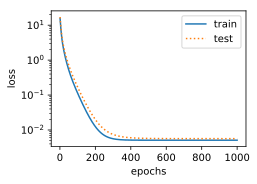

In [6]:
num_epochs = 1000
fit_and_plot(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4], labels[:n_train], labels[n_train:])

##  Linear Function Fitting (Underfitting)

final epoch: train loss 2.742919 test_loss 3.8024716
weight: [[ 4.8857613  4.197795  -2.7252064]]


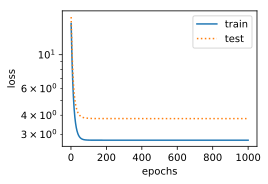

In [7]:
num_epochs = 1000
fit_and_plot(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3], labels[:n_train], labels[n_train:])

##  Insufficient Training (Overfitting)

final epoch: train loss 0.00908249 test_loss 0.048801936
weight: [[ 4.9968672e+00  1.3783135e+00 -3.3010449e+00  4.8227143e+00
  -3.4296358e-01  1.5838882e+00  2.0243047e-01  3.2511228e-01
  -1.3139635e-02  7.8069612e-02 -3.1510968e-02 -6.6216685e-02
   3.7529137e-02 -1.9485841e-02  6.2199634e-02  3.2203685e-02
   3.5000380e-02 -4.5971803e-02 -2.2483468e-02  2.9451256e-03]]


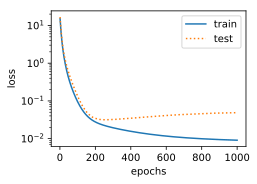

In [8]:
num_epochs = 1000
n_subset = 100  # subset of data to train on
n_degree = 20   # degree of polynomials
fit_and_plot(poly_features[1:n_subset, 0:n_degree], poly_features[n_train:, 0:n_degree],
             labels[1:n_subset], labels[n_train:])

# Problems

1. Can you solve the polynomial regression problem exactly? Hint - use linear algebra.

2. Model selection for polynomials
    * Plot the training error vs. model complexity (degree of the polynomial). What do you observe?
    * Plot the test error in this case.
    * Generate the same graph as a function of the amount of data?

3. What happens if you drop the normalization of the polynomial features $x^i$ by $1/i!$. Can you fix this in some other way?

4. What degree of polynomial do you need to reduce the training error to 0?

5. Can you ever expect to see 0 generalization error?